## Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
!pip install -qq svgpath2mpl svgpathtools

In [251]:
# Standard library
import json
from math import ceil, isfinite
from pathlib import Path
from warnings import filterwarnings

# Plotting, figure settings, math
import matplotlib
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.transforms import Affine2D
from numpy import array, clip, eye, mean, ndarray, pi, set_printoptions, stack
from svgpath2mpl import parse_path
from svgpathtools import svg2paths

# ProMis
from promis import ProMis, StaRMap
from promis.geo import (
    CartesianCollection,
    CartesianMap,
    CartesianRasterBand,
    PolarCollection,
    PolarLocation,
)
from promis.loaders import NauticalChartLoader
from promis.logic.spatial.depth import Depth


In [4]:
# Use full width of juptyer notebook
set_printoptions(linewidth=180, formatter={"float_kind": "{:4.6f}".format})
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

sns.set_theme(style="ticks", rc={"figure.figsize": (8, 3), "legend.title_fontsize": 15})
sns.set_style({"font.family": "serif", "font.serif": "Times New Roman"})

filterwarnings("ignore", module="tqdm.auto", message="IProgress not found")

## General setting

In [5]:
setting = "New York Harbor"
bbox = (
    # (lat, lon) lower left
    (40.4, -74.1),
    # (lat, lon) upper right
    (40.7, -73.8),
)

# setting = "Port of Charleston, South Carolina"
# bbox = (
#     # (lat, lon) lower left
#     (32.75, -79.97),
#     # (lat, lon) upper right
#     (32.875, -79.87),
# )

# setting = "Baltimore"
# bbox = (
#     # (lat, lon) lower left
#     (39.174, -76.6304993),
#     # (lat, lon) upper right
#     (39.29, -76.4495423),
# )

# setting = "Port of Virginia (Norfolk)"
# bbox = (
#     # (lat, lon) lower left
#     (36.7711453, -76.4994133),
#     # (lat, lon) upper right
#     (37.3020172, -75.8786833),
# )

In [6]:
origin = PolarLocation(
    latitude=mean([bbox[0][0], bbox[1][0]]), longitude=mean([bbox[0][1], bbox[1][1]])
)
width = PolarLocation(latitude=bbox[0][0], longitude=bbox[0][1]).distance(
    PolarLocation(latitude=bbox[0][0], longitude=bbox[1][1])
)
height = PolarLocation(latitude=bbox[0][0], longitude=bbox[0][1]).distance(
    PolarLocation(latitude=bbox[1][0], longitude=bbox[0][1])
)
dimensions = width, height
dimensions

(25468.03852707448, 33313.56617274144)

In [46]:
target_resolution = (200, 200)
support_resolution = (50, 50)

## Load chart data

This only needs to be done once.

In [ ]:
uam = NauticalChartLoader(
    chart_root=Path(".").absolute().parent / "data" / "us_charts-ny",  #  / "US4NY1AM"
    origin=origin,
    dimensions=dimensions,
).load_chart_data()

uam.apply_covariance(20.0 * eye(2))

In [9]:
print(f"Loaded {len(uam.features)} features:")
print()

for feature in uam.features:
    # Water is visualized below anyways
    if feature.location_type != "water":
        print(f"{type(feature).__name__} - {feature.location_type}: \t{feature.name}")

Loaded 5877 features:

CartesianPolygon - anchorage: 	US5NYCBF#02262F61D8911940 (Anchorage area): "Lower Bay Anchorage Area Number 28"
CartesianLocation - obstruction: 	US5NYCBF#02260220BECE0032 (Buoy (BOYLAT)): "Chapel Hill South Channel Buoy 13"
CartesianLocation - obstruction: 	US5NYCBF#02260220CE840032 (Buoy (BOYLAT)): "Chapel Hill North Channel Buoy 14"
CartesianLocation - obstruction: 	US5NYCBF#02260220C0E00032 (Buoy (BOYLAT)): "Ambrose Channel Lighted Gong Buoy 21"
CartesianLocation - obstruction: 	US5NYCBF#02260220BF1C0032 (Buoy (BOYLAT)): "Chapel Hill North Channel Lighted Bell Buoy 17"
CartesianLocation - obstruction: 	US5NYCBF#02260220CE850032 (Buoy (BOYLAT)): "Chapel Hill South Channel Junction Buoy CH"
CartesianLocation - obstruction: 	US5NYCBF#0226022435400032 (Buoy (BOYLAT)): "Chapel Hill South Channel Buoy 11"
CartesianLocation - obstruction: 	US5NYCBF#02260220BED40032 (Buoy (BOYLAT)): "Ambrose Channel Lighted Buoy AC"
CartesianLocation - obstruction: 	US5NYCBF#02260224

In [10]:
uam.save("nautical_chart_uam.pkl")

## Prepare the mission landscape

In [11]:
# Load a UAM
uam = CartesianMap.load("nautical_chart_uam.pkl")

# We create a statistical relational map (StaR Map) to represent the
# stochastic relationships in the environment, computing a raster of 100 x 100 points
# using linear interpolation of a sample set
target = CartesianRasterBand(origin, target_resolution, width, height)
star_map = StaRMap(target, uam, method="nearest")

# The sample points for which the relations will be computed directly
support = CartesianRasterBand(origin, support_resolution, width, height)

# We now compute the Distance and Over relationships for the selected points
# For this, we take many random samples from generated/possible map variations
star_map.add_support_points(support, 5)

star_map.save("nautical_chart_star_map.pkl")

## Visualize the relations

In [12]:
star_map = StaRMap.load("nautical_chart_star_map.pkl")

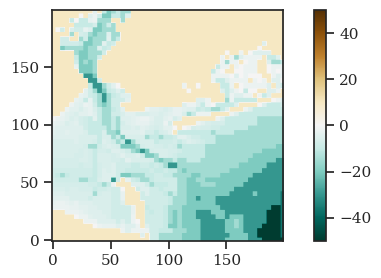

<Figure size 800x300 with 0 Axes>

In [13]:
# We first plot the depth since it is not asoociated with a specific location type
depth: Depth = star_map.get("depth", None)
depth.plot(target_resolution)
plt.show()
plt.clf()

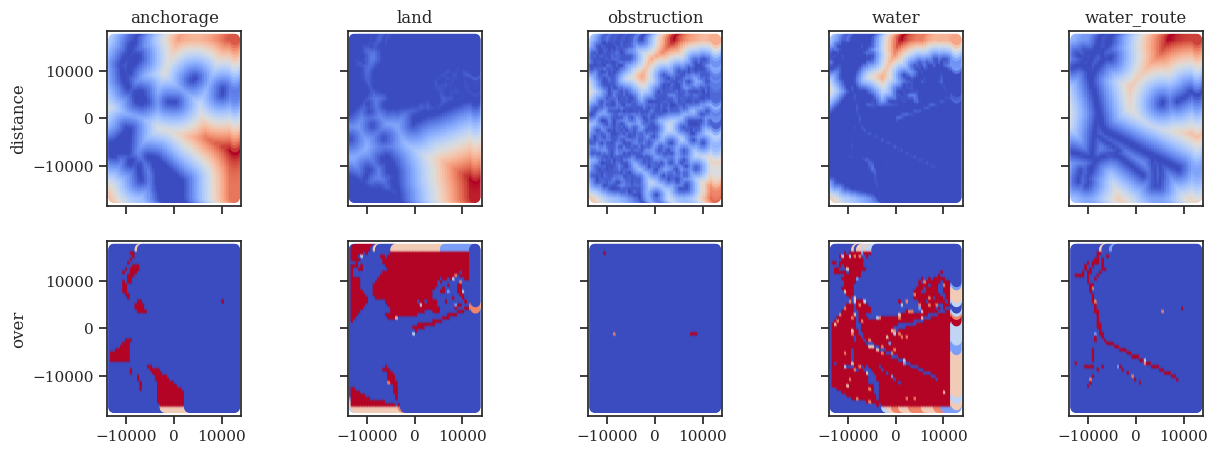

<Figure size 800x300 with 0 Axes>

In [16]:
# Plot an overview of the map
all_relation_types = sorted(star_map.relation_types - {"depth"})
all_location_types = sorted(set(star_map.location_types) - {None})

# Create one row per relation type and one column per location type
fig, axes = plt.subplots(
    len(all_relation_types), len(all_location_types), figsize=(15, 5), sharex=True, sharey=True
)

for i, relation_type in enumerate(all_relation_types):
    for j, location_type in enumerate(all_location_types):
        # Get the axis for the current row and column
        ax = axes[i, j]

        # Label the rows and columns
        if j == 0:
            ax.set_ylabel(relation_type)
        if i == 0:
            ax.set_title(location_type)

        # Get the relation and visualize it
        relation = star_map.get(relation_type, location_type)
        relation.parameters.scatter(axis=ax, cmap="coolwarm")

        # if j == len(all_location_types) - 1:
        #     plt.colorbar()

plt.show()
plt.clf()

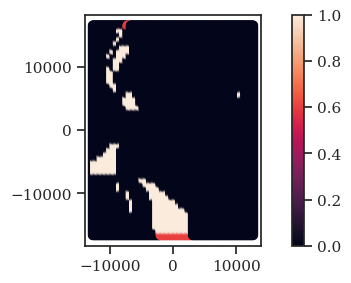

<Figure size 800x300 with 0 Axes>

In [17]:
relation = star_map.get("over", "anchorage")
relation.parameters.scatter(vmin=0)
plt.colorbar()
plt.show()
plt.clf()

## Run some inference

In [18]:
# In ProMis, we define the constraints of the mission
# as hybrid probabilistic first-order logic programs

logic = """
landscape(X) :- over(X, water_route), depth(X) < -4.
"""

# Solve mission constraints using StaRMap parameters and multiprocessing
promis = ProMis(star_map, logic)
landscape = promis.solve(n_jobs=12, batch_size=10, show_progress=False)


landscape(X) :- over(X, water_route), depth(X) < -4.

query(landscape(x_0)).
depth(x_0) ~ normal(10.0, 0.25).
0.0::over(x_0, water_route).

query(landscape(x_1)).
depth(x_1) ~ normal(10.0, 0.25).
0.0::over(x_1, water_route).

query(landscape(x_2)).
depth(x_2) ~ normal(10.0, 0.25).
0.0::over(x_2, water_route).

query(landscape(x_3)).
depth(x_3) ~ normal(10.0, 0.25).
0.0::over(x_3, water_route).

query(landscape(x_4)).
depth(x_4) ~ normal(10.0, 0.25).
0.0::over(x_4, water_route).

query(landscape(x_5)).
depth(x_5) ~ normal(10.0, 0.25).
0.0::over(x_5, water_route).

query(landscape(x_6)).
depth(x_6) ~ normal(10.0, 0.25).
0.0::over(x_6, water_route).

query(landscape(x_7)).
depth(x_7) ~ normal(10.0, 0.25).
0.0::over(x_7, water_route).

query(landscape(x_8)).
depth(x_8) ~ normal(10.0, 0.25).
0.0::over(x_8, water_route).

query(landscape(x_9)).
depth(x_9) ~ normal(10.0, 0.25).
0.0::over(x_9, water_route).




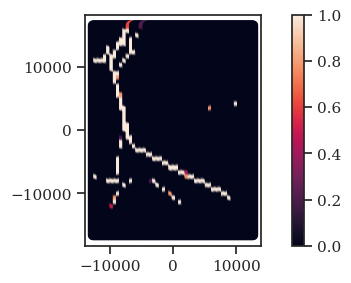

<Figure size 800x300 with 0 Axes>

In [19]:
# Show the resulting landscape
landscape.scatter()
plt.colorbar()
plt.show()
plt.clf()

In [20]:
promis.save("nautical_chart_promis.pkl")

### Query the landscape for specific locations

In [21]:
promis = ProMis.load("nautical_chart_promis.pkl")


landscape(X) :- over(X, water_route), depth(X) < -4.

query(landscape(x_0)).
depth(x_0) ~ normal(-6.0, 0.25).
0.0::over(x_0, water_route).

query(landscape(x_1)).
depth(x_1) ~ normal(-4.0, 0.25).
0.0::over(x_1, water_route).

query(landscape(x_2)).
depth(x_2) ~ normal(-6.0, 0.25).
0.0::over(x_2, water_route).




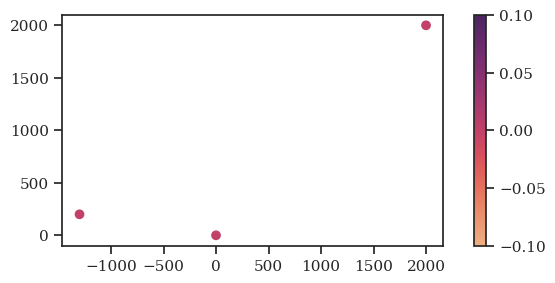

,east,north,v0
0,-1300.0,200.0,0.0
1,0.0,0.0,0.0
2,2000.0,2000.0,0.0


<Figure size 800x300 with 0 Axes>

In [22]:
def solve_at(promis: ProMis, query_locations: ndarray) -> CartesianCollection:
    """Solve the landscape at specific query locations.

    Note:
        Modifies the target of the ProMis object to the query locations.
    """

    # Validate the query location shape
    assert (
        len(query_locations.shape) == 2
    ), f"Query locations must be 2D, got {query_locations.shape}"
    assert query_locations.shape[1] == 2, "Query locations must be 2D"

    # Update the target of the ProMis object to the query locations
    new_target = CartesianCollection(
        origin=star_map.uam.origin, dimensions=star_map.target.dimensions
    )
    new_target.append_with_default(query_locations, value=0.0)
    promis.star_map.target = new_target

    # Solve the ProMis inference problem at the target locations
    return promis.solve(n_jobs=12, batch_size=10, show_progress=False)


# Showcase the solution at specific locations
result = solve_at(promis, query_locations=array([[-1300, 200], [0, 0], [2000, 2000]]))

# Show the resulting landscape
result.scatter(cmap="flare")
plt.colorbar()
plt.show()
plt.clf()

# The resulting datafram retains the order of the query locations
# The relevant inference solution could now be extracted using the `v0` key
result.data

## Load some AIS data

In [23]:
vessel_types = json.loads((Path("..") / "data" / "vessel_types_simplified.json").read_text())
# vessel_types

In [24]:
def load_ais(
    path: str | Path, bbox: None | tuple[tuple[float, float], tuple[float, float]]
) -> pd.DataFrame:
    # Read the csv into pandas
    df = pd.read_csv(path)

    # Filter by bounding box
    if bbox is not None:
        # This is a overly simplistic bounding box filter that only works on moderate latitudes
        # and far from the dateline
        df = df[
            (df["LAT"] > bbox[0][0])
            & (df["LAT"] < bbox[1][0])
            & (df["LON"] > bbox[0][1])
            & (df["LON"] < bbox[1][1])
        ]

    # Sort by time per ship
    df.sort_values(["MMSI", "BaseDateTime"], inplace=True)

    df.loc[df["VesselType"].isna(), "VesselType"] = 0  # Zero means unknown

    df["VesselType"] = df["VesselType"].astype(int)
    df["VesselTypeName"] = df["VesselType"].astype(str).map(vessel_types)

    return df


df = load_ais(Path("..") / "data" / "ais" / "AIS_2023_08_01.csv", bbox=bbox)
df

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass,VesselTypeName
4127220,99258652,2023-08-01T12:17:26,40.64471,-74.02892,0.2,360.0,511.0,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN,A,Not available
6356009,232040168,2023-08-01T18:14:16,40.41563,-74.02070,102.3,71.0,106.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft
6390267,232040168,2023-08-01T18:22:00,40.41702,-74.01857,5.5,31.8,41.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft
6391376,232040168,2023-08-01T18:24:03,40.42008,-74.01790,7.9,349.8,2.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft
6418027,232040168,2023-08-01T18:27:35,40.42827,-74.01943,9.5,352.2,358.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8317539,636093148,2023-08-01T23:45:44,40.67079,-74.07980,0.0,299.0,299.0,TANGIER EXPRESS,IMO9525900,5LDS8,74,5.0,366.0,48.0,11.8,74.0,A,"Cargo, hazardous"
8313370,636093148,2023-08-01T23:48:44,40.67079,-74.07980,0.0,299.1,299.0,TANGIER EXPRESS,IMO9525900,5LDS8,74,5.0,366.0,48.0,11.8,74.0,A,"Cargo, hazardous"
8354899,636093148,2023-08-01T23:51:44,40.67079,-74.07980,0.0,299.1,299.0,TANGIER EXPRESS,IMO9525900,5LDS8,74,5.0,366.0,48.0,11.8,74.0,A,"Cargo, hazardous"
8351117,636093148,2023-08-01T23:54:45,40.67079,-74.07980,0.0,299.2,299.0,TANGIER EXPRESS,IMO9525900,5LDS8,74,5.0,366.0,48.0,11.8,74.0,A,"Cargo, hazardous"


In [101]:
collection = PolarCollection(origin=origin, dimensions=0)
collection.append_with_default(df[["LON", "LAT"]].values, value=())
cartesian = collection.to_cartesian()

df.loc[:, "East"] = cartesian.data["east"].values
df.loc[:, "North"] = cartesian.data["north"].values
df

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass,VesselTypeName,East,North
6356009,232040168,2023-08-01T18:14:16,40.41563,-74.02070,102.3,71.0,106.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,-6000.582615,-14918.571967
6390267,232040168,2023-08-01T18:22:00,40.41702,-74.01857,5.5,31.8,41.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,-5819.681496,-14764.365122
6391376,232040168,2023-08-01T18:24:03,40.42008,-74.01790,7.9,349.8,2.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,-5762.556086,-14424.618369
6418027,232040168,2023-08-01T18:27:35,40.42827,-74.01943,9.5,352.2,358.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,-5891.689951,-13515.076873
6419256,232040168,2023-08-01T18:28:39,40.43095,-74.02005,9.5,353.6,358.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,-5944.065951,-13217.440337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8317539,636093148,2023-08-01T23:45:44,40.67079,-74.07980,0.0,299.0,299.0,TANGIER EXPRESS,IMO9525900,5LDS8,74,5.0,366.0,48.0,11.8,74.0,A,"Cargo, hazardous",-10974.904808,13421.394588
8313370,636093148,2023-08-01T23:48:44,40.67079,-74.07980,0.0,299.1,299.0,TANGIER EXPRESS,IMO9525900,5LDS8,74,5.0,366.0,48.0,11.8,74.0,A,"Cargo, hazardous",-10974.904808,13421.394588
8354899,636093148,2023-08-01T23:51:44,40.67079,-74.07980,0.0,299.1,299.0,TANGIER EXPRESS,IMO9525900,5LDS8,74,5.0,366.0,48.0,11.8,74.0,A,"Cargo, hazardous",-10974.904808,13421.394588
8351117,636093148,2023-08-01T23:54:45,40.67079,-74.07980,0.0,299.2,299.0,TANGIER EXPRESS,IMO9525900,5LDS8,74,5.0,366.0,48.0,11.8,74.0,A,"Cargo, hazardous",-10974.904808,13421.394588


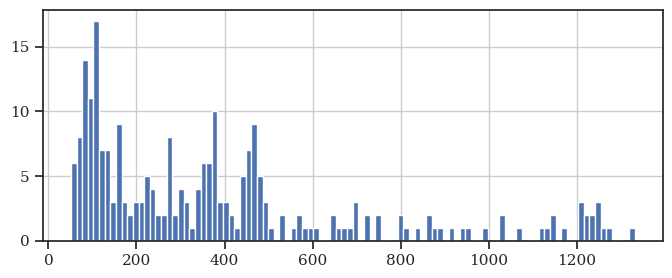

In [102]:
df["MMSI"].value_counts().hist(bins=100)
pass

In [103]:
MMSIs = df["MMSI"].value_counts()
relevant_MMSIs = MMSIs[MMSIs > 50].index
df = df[df["MMSI"].isin(relevant_MMSIs)]

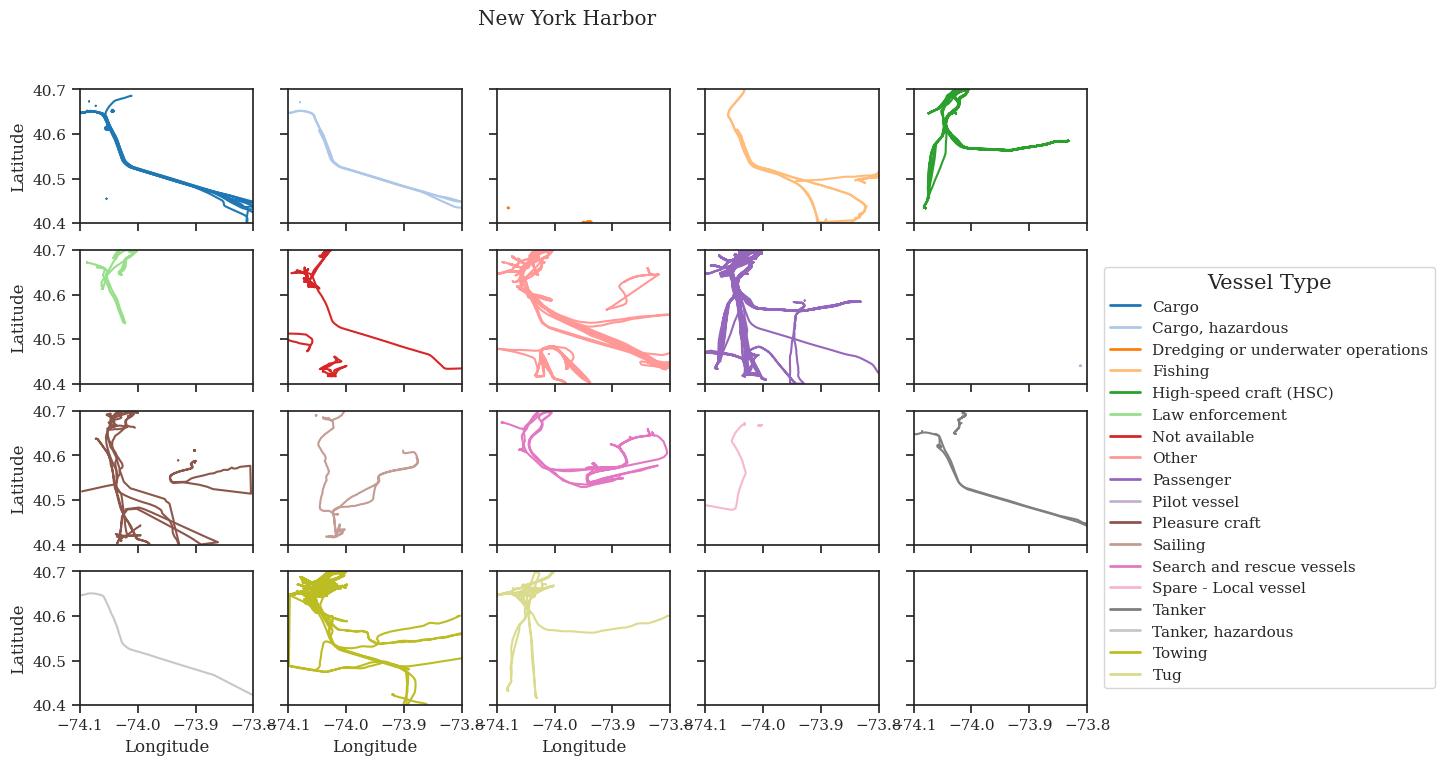

<Figure size 800x300 with 0 Axes>

In [104]:
vessel_type_to_index = {
    vessel_type: i for i, vessel_type in enumerate(sorted(df["VesselTypeName"].unique()))
}
palette = sns.color_palette("tab20", len(vessel_type_to_index))

relevant_vessel_types = df["VesselTypeName"].unique()

cols = 5
all_rows = ceil(len(relevant_vessel_types) / cols)
fig, ax = plt.subplots(ncols=cols, nrows=all_rows, figsize=(13, 8), sharex=True, sharey=True)

for (vessel_type, i), ax in zip(vessel_type_to_index.items(), ax.flatten()):
    for mmsi in relevant_MMSIs:
        df_ = df[df["MMSI"] == mmsi]
        if relevant_vessel_types is not None and df_["VesselTypeName"].iloc[0] != vessel_type:
            continue
        vessel_type = df_["VesselTypeName"].iloc[0]
        color = palette[vessel_type_to_index[vessel_type]]
        ax.plot(df_["LON"], df_["LAT"], c=color)
        # plt.scatter(df_["LON"], df_["LAT"], c=df_["SOG"], cmap="viridis", s=8)

    # plt.colorbar()

    ax.set_xlim(bbox[0][1], bbox[1][1])
    if i // cols == all_rows - 1:
        ax.set_xlabel("Longitude")
    ax.set_ylim(bbox[0][0], bbox[1][0])
    if i % cols == 0:
        ax.set_ylabel("Latitude")
    # ax.set_aspect("equal")

    # if the center right ahdn side
    col = i % cols
    row = i // cols
    if col == cols - 1 and row == len(relevant_vessel_types) // cols - 1:
        ax.legend(
            [
                plt.Line2D([0], [0], color=palette[i], lw=2, label=vessel_type)
                for i, vessel_type in enumerate(vessel_type_to_index)
            ],
            vessel_type_to_index.keys(),
            title="Vessel Type",
            loc="center left",
            bbox_to_anchor=(1.05, 0.5),
        )

plt.suptitle(setting)

plt.savefig(Path(".") / "plots" / f"ais-{setting}-some.pdf", bbox_inches="tight")

plt.show()
plt.clf()

pass

In [105]:
relevant_vessel_types = [
    "Cargo",
    "Cargo hazardous",
    "Search and rescue vessels",
    "Towing",
    "Other",
    "Tanker",
    "Tanker hazardous",
    "Passenger",
]

In [106]:
# for mmsi in relevant_MMSIs:
#     df_ = df[df["MMSI"] == mmsi]
#     if df_["VesselTypeName"].iloc[0] not in relevant_vessel_types:
#         continue

#     plt.plot(df_["LON"], df_["LAT"], c=color)
#     plt.xlim(bbox[0][1], bbox[1][1])
#     plt.ylim(bbox[0][0], bbox[1][0])
#     plt.gca().set_aspect("equal")

#     path = Path(".") / "plots" / f"ais-{setting}" / df_["VesselTypeName"].iloc[0]
#     path.mkdir(exist_ok=True, parents=True)
#     plt.savefig(path / f"{mmsi}.pdf", bbox_inches="tight")
#     plt.clf()

# pass

In [107]:
track_mmsi = 636017103
track_mmsi

636017103

## Use the landscape to filter with agent constitution

In [108]:
import numpy as np
from matplotlib.animation import FuncAnimation
from scipy.stats import norm, uniform

from promis.estimators.filters.particle import (
    ParticleFilter,
    gaussian_noise,
    independent_sample,
    squared_error,
)

In [109]:
df_ = df[df["MMSI"] == track_mmsi]
df_


,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass,VesselTypeName,East,North
3960115,636017103,2023-08-01T11:49:35,40.44721,-73.80007,6.3,267.2,270.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,12719.189958,-11403.440125
4007616,636017103,2023-08-01T11:50:44,40.44706,-73.80274,6.3,267.0,270.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,12492.710366,-11420.477721
3975932,636017103,2023-08-01T11:51:55,40.44698,-73.80548,6.3,267.8,270.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,12260.278629,-11429.745157
8645385,636017103,2023-08-01T11:53:06,40.44686,-73.80823,6.3,267.9,270.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,12027.005130,-11443.448475
3989953,636017103,2023-08-01T11:54:15,40.44682,-73.81085,6.1,269.9,276.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,11804.745333,-11448.243697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4648379,636017103,2023-08-01T13:40:39,40.64977,-74.08801,5.8,246.1,245.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,-11672.743889,11088.235617
4630139,636017103,2023-08-01T13:41:48,40.64906,-74.09025,5.8,247.6,246.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,-11862.326566,11009.691808
4657127,636017103,2023-08-01T13:42:58,40.64832,-74.09258,5.9,247.5,247.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,-12059.530932,10927.833752
4646210,636017103,2023-08-01T13:44:09,40.64769,-74.09501,6.0,256.7,259.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,-12265.177691,10858.210053


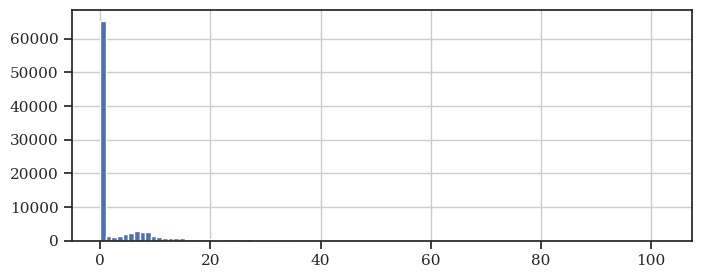

In [110]:
df["SOG"].hist(bins=100)
pass

% Background knowledge
is_deep(X) :- A is depth(X), B is current_draft , A + B < -1.

0.95::is_safe(X) :- is_deep(X), distance(X, land) > 100, \+ over(X, anchorage).

bound_to_main_routes :- is_cargo ; is_cargo_hazardous ;
    is_tanker ; is_tanker_hazardous ; is_towing ;
    length > 50.
follows_main_routes(X) :- \+  bound_to_main_routes ; distance(X, water_route) < 400 ;
    distance(X, water_route) > 2000.
is_sane_speed(X) :- \+ over(X, anchorage) ; speed_over_ground < 10.
is_legal(X) :- follows_main_routes(X), is_sane_speed(X).

is_useful(X) :- \+ is_search_and_rescue_vessels.
is_useful(X) :- is_search_and_rescue_vessels, distance(X, land) < 500.

landscape(X) :- is_safe(X), is_legal(X), is_useful(X).

is_cargo.
0::is_cargo_hazardous.
0::is_search_and_rescue_vessels.
0::is_towing.
0::is_other.
0::is_tanker.
0::is_tanker_hazardous.
0::is_passenger.
length ~ normal(300.0, 15.0).
current_draft ~ normal(3, 1).
speed_over_ground ~ normal(6.3, 0.63).


query(landscape(x_0)).
distance(x_0

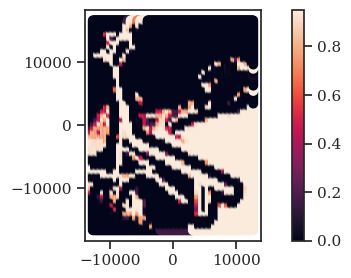

<Figure size 800x300 with 0 Axes>

In [125]:
metadata = df_.iloc[0]

logic = r"""% Background knowledge
is_deep(X) :- A is depth(X), B is current_draft , A + B < -1.

0.95::is_safe(X) :- is_deep(X), distance(X, land) > 100, \+ over(X, anchorage).

bound_to_main_routes :- is_cargo ; is_cargo_hazardous ;
    is_tanker ; is_tanker_hazardous ; is_towing ;
    length > 50.
follows_main_routes(X) :- \+  bound_to_main_routes ; distance(X, water_route) < 400 ;
    distance(X, water_route) > 2000.
is_sane_speed(X) :- \+ over(X, anchorage) ; speed_over_ground < 10.
is_legal(X) :- follows_main_routes(X), is_sane_speed(X).

is_useful(X) :- \+ is_search_and_rescue_vessels.
is_useful(X) :- is_search_and_rescue_vessels, distance(X, land) < 500.

landscape(X) :- is_safe(X), is_legal(X), is_useful(X).
"""

vessel_type = metadata["VesselTypeName"].replace(" ", "_").lower()
logic += f"\nis_{vessel_type}."
for vessel_type in relevant_vessel_types:
    if vessel_type != metadata["VesselTypeName"]:
        logic += f"\n0::is_{vessel_type.replace(' ', '_').lower()}."

length = metadata["Length"]
if isfinite(length) and length > 0:
    logic += f"\nlength ~ normal({length}, {length*0.05})."
else:
    # Some prior knowledge
    logic += "\nlength ~ normal(30, 10)."

draft = metadata["Draft"]
if isfinite(length) and draft > 0:
    logic += f"\ncurrent_draft ~ normal({draft}, {draft*0.1})."
else:
    # Some prior knowledge
    logic += "\ncurrent_draft ~ normal(3, 1)."

# TODO: Time varying!
speed_over_ground = metadata["SOG"]
if isfinite(speed_over_ground):
    logic += f"\nspeed_over_ground ~ normal({speed_over_ground}, {speed_over_ground*0.1})."
else:
    # Some prior knowledge
    logic += "\nspeed_over_ground ~ normal(5, 5)."

logic += "\n\n"  # Add newlines for better readability

promis = ProMis(star_map, logic)
landscape = promis.solve(n_jobs=10, batch_size=5, show_progress=False)

landscape.scatter()
plt.colorbar()
plt.show()
plt.clf()

In [240]:
typical_ship_speed = 5  # meters per second
sample_time = 60  # seconds

In [266]:
ground_truth = stack((df_["East"], df_["North"], df_["COG"], df_["SOG"])).T
ground_truth_positions = ground_truth[:, :2]

In [267]:
def plot_trajectories(all_positions: ndarray, label: str | None = "Trajectory {}", **kwargs):
    if len(all_positions.shape) == 2:
        all_positions = all_positions[None, ...]
    for i, positions in enumerate(all_positions):
        plt.plot(*zip(*positions), label=label.format(i) if label else None, **kwargs)

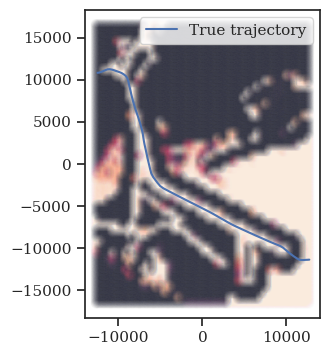

<Figure size 800x300 with 0 Axes>

In [268]:
plt.figure(figsize=(6, 4))
landscape.scatter(alpha=0.02)
plot_trajectories(ground_truth_positions, label="True trajectory")
plt.legend()
plt.show()
plt.clf()
pass

In [269]:
def plot_trajectories_animated(positions, filename: str = "trajectory.gif") -> None:
    fig, _ = plt.subplots()
    landscape.scatter()
    (line,) = plt.plot(*zip(*positions), label="Ship Position")
    plt.colorbar()

    def update(num, x, y, line):
        line.set_data(x[:num], y[:num])
        line.axes.axis([-width / 2, width / 2, -height / 2, height / 2])
        return (line,)

    ani = FuncAnimation(
        fig,
        update,
        len(positions),
        fargs=[positions[:, 0], positions[:, 1], line],
        interval=1000 / 60,
        blit=True,
    )
    ani.save(filename)
    plt.clf()


# plot_trajectories_animated(ground_truth)

In [309]:
# We define the first and second derivatives in polar coordinates
# since that is how the AIS data is given (for boat speed and direction)
# and is is quite natural for the problem at hand (ships change direction
# more often than speed)
column_names = ["x", "y", "dphi", "dr", "ddphi", "ddr"]

# prior sampling function for each variable
prior_fn = independent_sample(
    [
        uniform(loc=-width / 2, scale=width).rvs,
        uniform(loc=-height / 2, scale=height).rvs,
        uniform(loc=0, scale=2 * pi).rvs,
        norm(loc=typical_ship_speed, scale=0.5 * typical_ship_speed).rvs,
        norm(loc=0, scale=0.1 * 2 * pi).rvs,
        norm(loc=0, scale=0.1 * typical_ship_speed).rvs,
    ]
)


def state_forward_model(x: ndarray) -> ndarray:
    """Very simple linear dynamics: pos += dpos and dpos += ddpos."""
    xp = np.array(x)

    # However, we need to convert the polar coordinates to cartesian
    dx = np.cos(xp[2]) * xp[3]
    dy = np.sin(xp[2]) * xp[3]
    xp[0] += dx * sample_time
    xp[1] += dy * sample_time

    xp[3] = clip(xp[3], 0, None)

    # First and second derivatives are both in polar coordinates
    # xp[[2, 3]] += xp[[4, 5]] * sample_time

    return xp


def weight_fn(hyp, obs, use_landscape: bool = False) -> ndarray:
    # Compute by distance to observations
    weight = squared_error(hyp, obs, sigma=typical_ship_speed * 100)
    if use_landscape:
        from_landscape = solve_at(promis, hyp).data["v0"].to_numpy()

        # plt.hist(from_landscape)
        # plt.xlabel("Landscape Value")
        # plt.ylabel("Frequency")
        # plt.show()
        # plt.clf()

        weight *= from_landscape
    return weight


# create the filter
pf = ParticleFilter(
    prior_fn=prior_fn,
    observe_fn=lambda x: x[:, :4],
    n_particles=50,
    dynamics_fn=state_forward_model,
    noise_fn=lambda x: gaussian_noise(
        x,
        sigmas=[
            typical_ship_speed * sample_time,
            typical_ship_speed * sample_time,
            0.02 * 2 * pi,
            typical_ship_speed * 0.05,
            0.02**2 * 2 * pi,
            typical_ship_speed * 0.05**2,
        ],
    ),
    weight_fn=weight_fn,
    resample_proportion=0.01,
    column_names=column_names,
)

trace_all_particles = [pf.particles.copy()]  # only here we already have the initial particles
trace_state = []
trace_map_state = []
trace_hypotheses = []
trace_map_hypotheses = []

for i, obs in enumerate(ground_truth):
    if i < len(ground_truth) * 0.75:
        pf.update(obs)
    else:
        pf.update(None)

    trace_all_particles.append(pf.particles.copy())
    trace_state.append(pf.mean_state)
    trace_map_state.append(pf.map_state)
    trace_hypotheses.append(pf.mean_hypothesis)
    trace_map_hypotheses.append(pf.map_hypothesis)

trace_all_particles = array(trace_all_particles)
trace_state = array(trace_state)
trace_map_state = array(trace_map_state)
trace_hypotheses = array(trace_hypotheses)
trace_map_hypotheses = array(trace_map_hypotheses)

In [310]:
trace_all_particles.shape

(105, 50, 6)

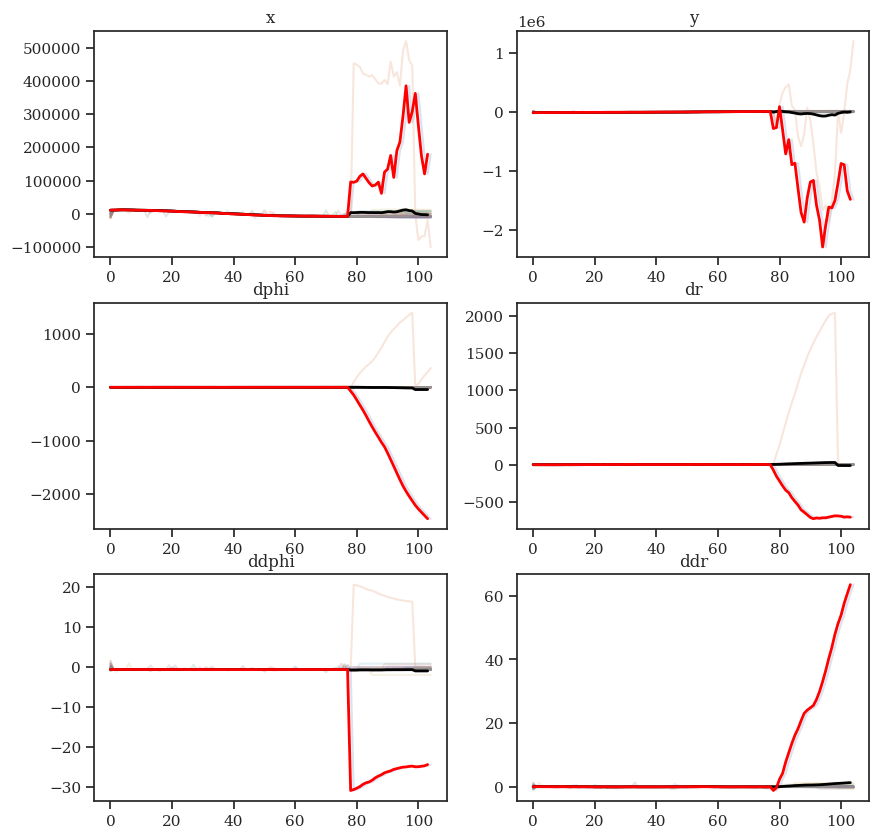

In [311]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.plot(trace_all_particles[:, :, i], alpha=0.2)
    ax.plot(trace_state[:, i], c="black", lw=2)
    ax.plot(trace_map_state[:, i], c="red", lw=2)
    ax.set_title(column_names[i])

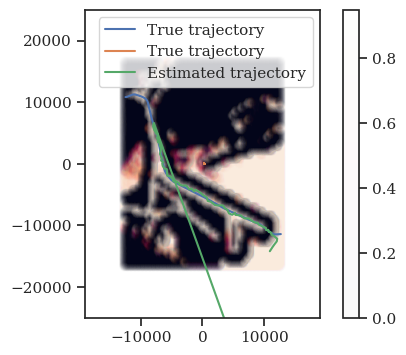

In [312]:
plt.figure(figsize=(6, 4))
landscape.scatter(alpha=0.02)
plot_trajectories(ground_truth, label="True trajectory")
plot_trajectories(trace_map_state[:, :2], label="Estimated trajectory")

# show_n_particles = 10
# plot_trajectories(trace_all_particles[:, :show_n_particles, :2].swapaxes(1, 0), label=None)

scale = 1.5
plt.gca().set_xlim(-width / 2 * scale, width / 2 * scale)
plt.gca().set_ylim(-height / 2 * scale, height / 2 * scale)

plt.colorbar()
plt.legend()
pass

In [278]:
coordinates = trace_all_particles[:, :, :2]

# Shape is (time, particles, state)
coordinates.shape

(105, 50, 2)

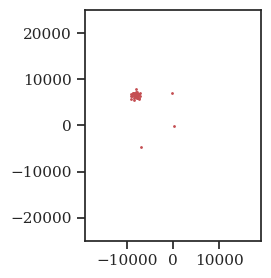

In [279]:
plt.gca().set_aspect("equal")
plt.scatter(*coordinates[80, ...].T, c="r", s=1)
plt.xlim(-width / 2 * scale, width / 2 * scale)
plt.ylim(-height / 2 * scale, height / 2 * scale)

pass

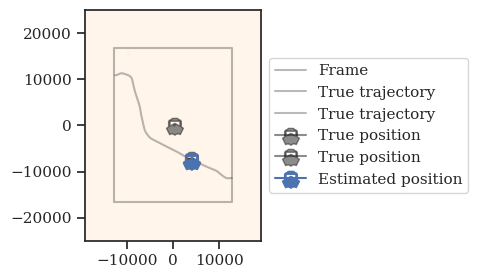

In [280]:
index = 30

plt.gca().set_aspect("equal")

# draw a box around the frame (-1500, -1500) to (1500, 1500)
plt.plot(
    [-width / 2, width / 2, width / 2, -width / 2, -width / 2],
    [-height / 2, -height / 2, height / 2, height / 2, -height / 2],
    "k-",
    alpha=0.3,
    label="Frame",
)

plot_trajectories(ground_truth, label="True trajectory", color="k", alpha=0.3)

plt.hist2d(
    *coordinates[index, ...].T,
    bins=50,
    range=[[-width / 2 * scale, width / 2 * scale], [-height / 2 * scale, height / 2 * scale]],
    cmap="Oranges",
)

ship_marker = parse_path(svg2paths("ship-icon.svg")[1][0]["d"])
ship_marker.vertices -= ship_marker.vertices.mean(axis=0)
ship_marker = ship_marker.transformed(Affine2D().rotate_deg(180)).transformed(
    Affine2D().scale(-1, 1)
)

if index > 0:
    # Plot the ship position and position estimate at that time point
    plt.gca().plot(
        *ground_truth[index - 1],
        marker=ship_marker,
        markersize=14,
        label="True position",
        c="k",
        alpha=0.5,
    )
    plt.gca().plot(
        *trace_state[index - 1, :2],
        marker=ship_marker,
        markersize=14,
        label="Estimated position",
        c="b",
    )


plt.legend(
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)
pass